In [2]:
import sys
import os.path as osp

from copy import deepcopy
import datetime
import os
import pickle
import csv
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from multihist import Hist1d, Histdd
from tqdm.notebook import tqdm
import pandas as pd
from scipy import stats

import strax
import straxen
strax.utils.tqdm = tqdm  # use notebook-aware progress bar

In [3]:
st = straxen.contexts.xenonnt_online()

In [5]:
runs = st.select_runs(run_id='0085*',run_mode='*selftrigger*',available='lone_hits')

In [6]:
runs

,name,number,mode,start,end,tags,livetime,tags.name,raw_records_available,peak_basics_available,lone_hits_available
1367,008525,8525,xenonnt_selftrigger_commissioning_lowe,2020-07-08 17:09:19.500,2020-07-08 18:09:21.830,,01:00:02.330000,NaN,True,True,True
1368,008526,8526,xenonnt_selftrigger_commissioning_lowe,2020-07-08 18:09:53.945,2020-07-08 19:09:55.270,,01:00:01.325000,NaN,False,True,True
1369,008527,8527,xenonnt_selftrigger_commissioning_lowe,2020-07-08 19:10:25.380,2020-07-08 20:10:27.790,,01:00:02.410000,NaN,True,True,True
1370,008528,8528,xenonnt_selftrigger_commissioning_lowe,2020-07-08 20:10:59.912,2020-07-08 21:11:02.421,,01:00:02.509000,NaN,False,True,True
1373,008531,8531,xenonnt_selftrigger_commissioning_lowe,2020-07-08 23:12:44.149,2020-07-09 00:12:47.749,,01:00:03.600000,NaN,False,True,True
1374,008532,8532,xenonnt_selftrigger_commissioning_lowe,2020-07-09 00:13:22.873,2020-07-09 01:13:25.307,,01:00:02.434000,NaN,False,True,True


In [7]:
def plot_lone_hits(run_name,pmt):
    lone_hits = st.get_array(run_name,'lone_hits',seconds_range=(0,30),
                         selection_str=(f'(channel=={pmt}) & (height>25)'))
    lh_area = Hist1d(lone_hits['area'], bins=(np.linspace(0, 2000, 200)))
    lh_area.plot()
    plt.figure(1)
    plt.xlabel("lone hits area (ADC)", ha='right', x=1)
    plt.ylabel("events", ha='right', y=1)
    lh = Histdd(lone_hits['area'], lone_hits['length']*lone_hits['dt'],
                    bins=(np.linspace(0, 2000, 200), np.linspace(0, 250, 25)))
    plt.figure(2)
    lh.plot(log_scale=True, cblabel='events')
    plt.xlabel("lone hits area (ADC)", ha='right', x=1)
    plt.ylabel("length (ns)", ha='right', y=1)

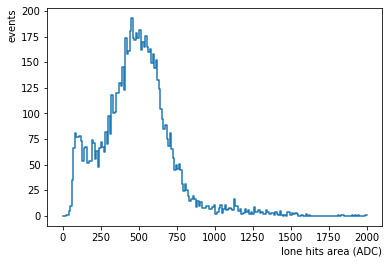

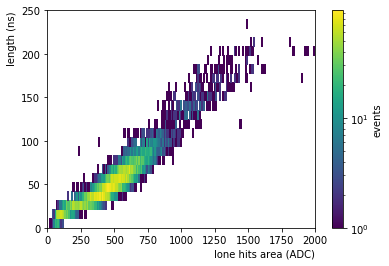

In [8]:
pmt = 0
plot_lone_hits(runs.iloc[0]['name'],pmt)

In [9]:
def pmt_gain(run_name,pmt,plot=True):
    lone_hits = st.get_array(run_name,'lone_hits',seconds_range=(0,30),
                         selection_str=(f'(channel=={pmt}) & (height>25)'))
    Z = 50
    e = 1.6021766208e-19
    w = 1e-9
    r = 2.25/2**14
    
    conv = r*w/(Z*1e-12)
    # PMT total charge
    pmt_charge = Hist1d(lone_hits['area']*conv, bins=200, range=(0,5) )
    #plt.hist(pdata['area'][pdata['channel']==id]*conv,
             #bins=200,range=(0,2),label=f"PMT n. {id}",
            #histtype='step')
    if plot:
        plt.figure(1)
        pmt_charge.plot(label=f"PMT n. {pmt}")
        plt.title(f'run {run_name}')
        plt.xlabel('total charge (pC)')
        plt.ylabel('counts', ha='right', y=1)
        plt.legend()
    
    # gain calculation
    el_hist, el_bin = np.histogram(lone_hits['area']*conv/e*1e-18,
             bins=200, range=(0,30))
    bin_max = np.where(el_hist > el_hist.max()*0.8)
    gain = np.average(el_bin[bin_max])
    if plot:
        plt.figure(2)
        p = plt.plot(el_bin[1:],el_hist,label=f'PMT n. {pmt}, gain: {gain:.1f}$\cdot 10^6$')
        plt.axvline(gain, linestyle=":", color = plt.gca().lines[-1].get_color())
        plt.title(f'run {run_name}')
        plt.xlabel('number of electrons $x10^6$')
        plt.ylabel('counts', ha='right', y=1)
        plt.legend()
    if np.isnan(gain): gain = 0
    return gain

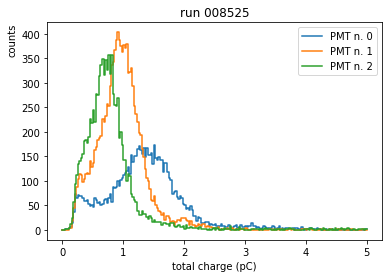

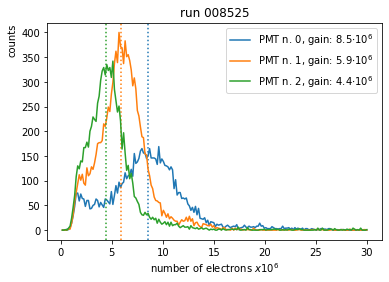

In [10]:
for pmt in range(3):
    pmt_gain(runs.iloc[0]['name'],pmt)

In [11]:
run_name = runs.iloc[0]['name']

In [12]:
n_pmt = 494
gains = np.zeros(n_pmt)
for i in range(n_pmt):
    gains[i] = pmt_gain(run_name,i,False)

/dali/lgrandi/strax/miniconda3/envs/strax/lib/python3.7/site-packages/numpy/lib/function_base.py:393: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/dali/lgrandi/strax/miniconda3/envs/strax/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


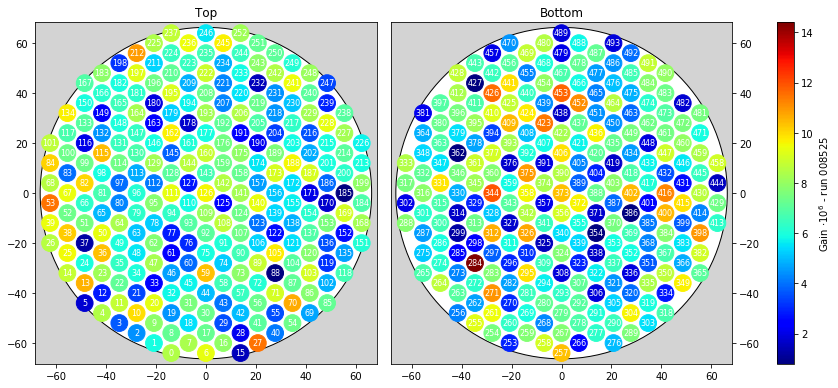

In [13]:
straxen.plot_pmts(gains, label=f'Gain $\cdot 10^6$ - run {run_name}',
                  cmap=plt.cm.jet,
                  vmin=0.8, log_scale=False)